In [2]:
from jax.config import config
config.update('jax_disable_jit', True)
config.update('jax_enable_x64', True)
# config.update("jax_debug_nans", True)

import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from jax.lax import scan
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
import pandas as pd
key = random.PRNGKey(0)

from utils_hyperelasticity import NODE_nobias
from utils import yprime_biaxial, getsigma
from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5 as mysolver

from utils import sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_RG_vmap, dPhi_vmap, plot45

In [3]:
def lmFv_residual(lm_F_v_trial, lm_F_v_prev, lm_F, Psi_neq_params, fiber_visc_params, useNODE, dt):
    lm_F_e = lm_F/lm_F_v_trial
    I4_e = lm_F_e**2
    I4_e_pr = np.max(np.array([1.0, I4_e])) #no stress in fiber if compressive
    if useNODE:
        tau_F_neq = 2*NODE_nobias(I4_e_pr-1.0, Psi_neq_params)*I4_e # Below (27)
        lm_F_v = lm_F_v_prev + dt*lm_F_v_prev*NODE_nobias(tau_F_neq, fiber_visc_params)
    else:
        k_neq = Psi_neq_params
        eta_F = fiber_visc_params
        tau_F_neq = k_neq*(np.exp(I4_e_pr-1.0)-1.0)*I4_e # Just a generic holzapfel-like term for I4
        lm_F_v = lm_F_v_prev + dt*lm_F_v_prev*tau_F_neq/eta_F # (37)
    
    return (lm_F_v - lm_F_v_trial)**2 + 1.0e-16
d_residual = grad(lmFv_residual)

In [4]:
def fiber_biaxial_update(prev, inp, F_params, useNODE):
    lm_F_v_prev, t_prev = prev
    t, lm1, lm2, lm3 = inp
    Psi_eq_params, Psi_neq_params, visc_params = F_params
    theta, fiber_visc_params = visc_params
    P = np.array([np.cos(theta), np.sin(theta), 1.0])
    M = np.outer(P,P)
    
    F = np.array([[lm1, 0, 0],
                  [0, lm2, 0],
                  [0, 0, lm3]])
    C = np.dot(F.T, F)
    m = np.dot(F, np.dot(M, F.T))/np.tensordot(C, M, axes=2)
    lm_F = np.sqrt(np.tensordot(C, M, axes=2)) # (2)

    # Do a NR to figure out lm_F^v
    dt = t-t_prev
    res = lambda x: lmFv_residual(x, lm_F_v_prev, lm_F, Psi_neq_params, fiber_visc_params, useNODE, dt)
    dres = grad(res)
    body_fun = lambda lm_F_v, dummy: [lm_F_v - res(lm_F_v)/dres(lm_F_v), res(lm_F_v)]
    lm_F_v, res = scan(body_fun, lm_F_v_prev, None, length=20)
    
    # Fiber stress
    lm_F_e = lm_F/lm_F_v
    I4_e = lm_F_e**2
    I4 = lm_F**2
    I3 = lm1*lm2*lm3

    I4_e_pr = np.max(np.array([0.0, I4_e])) #no stress in fiber if compressive
    I4_pr = np.max(np.array([0.0, I4])) #no stress in fiber if compressive
    if useNODE:
        tau_F_neq = 2*NODE_nobias(I4_e_pr-1.0, Psi_neq_params)*I4_e # Below (27)
        tau_F_eq  = 2*NODE_nobias(I4_pr-1.0, Psi_eq_params)*I4 # Below (27)
    else:
        k_neq = Psi_neq_params
        tau_F_neq = k_neq*(np.exp(I4_e_pr-1.0)-1.0)*I4_e # Just a generic holzapfel-like term for I4
        k_eq = Psi_eq_params
        tau_F_eq = k_eq*(np.exp(I4-1.0)-1.0)*I4 # Just a generic holzapfel-like term for I4
    
    sgm_F_neq = 2/np.sqrt(I3)*tau_F_neq*m
    sgm_F_eq = 2/np.sqrt(I3)*tau_F_eq*m

    carry = [lm_F_v, t]
    y = sgm_F_neq + sgm_F_eq, lm_F_v, res
    return carry, y

In [5]:
@partial(jit, static_argnums=(1,2,))
def biaxial_relax_aniso(params, norm, useNODE, time, lm1, lm2, dt0=0.5):
    ipeak1 = np.argmax(np.abs(np.around(lm1, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    ipeak2 = np.argmax(np.abs(np.around(lm2, 3)-1.0))
    ipeak = np.max(np.array([ipeak1,ipeak2]))
    tpeak = time[ipeak]
    lm1peak = lm1[ipeak]
    lm2peak = lm2[ipeak]

    lm1dot = (lm1peak-1.0)/tpeak
    lm2dot = (lm2peak-1.0)/tpeak

    M_params, F_params = params
    # Matrix part (identical to what we currently have)
    yprime = lambda t, y, args: np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,M_params,norm,useNODE))
    term = ODETerm(yprime)
    solver = mysolver()
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=dt0, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()
    sgm_M = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], M_params, norm, useNODE)

    
    inp = np.array([time[1:], lm1[1:], lm2[1:], lm3[1:],]).T
    init = [1.0, 0.0] #initial lm_F_v and time
    body_fun = lambda prev, inp: fiber_biaxial_update(prev, inp, F_params, useNODE)
    _, [sgm_F, lm_F_v, res] = scan(body_fun, init, inp)
    sgm_F = np.vstack([np.zeros([1,3,3]), sgm_F])
    sgm = sgm_F + sgm_M

    return sgm, lm1, lm2, lm3, lm1e, lm2e, lm3e, lm_F_v, res


In [6]:
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 


# Define loss functions
def biaxial_relax_loss(params, norm, useNODE, inp, out):
    sigma_pr,_,_,_,_,_,_,_,_ = biaxial_relax_aniso(params, norm, useNODE, inp[0], inp[1], inp[2])
    loss = np.mean((sigma_pr[:,0,0]-out[0])**2 + (sigma_pr[:,1,1]-out[1])**2)
    return loss
biaxial_relax_loss_vmap = vmap(biaxial_relax_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
biaxial_relax_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(biaxial_relax_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.mean((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.mean((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.mean((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.mean((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.mean((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.mean((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

NODE_nobias_vmap = vmap(NODE_nobias, in_axes=(0, None), out_axes=0)
def Psi_F_loss(params, norm, useNODE, I4, k):
    gt = k*(np.exp(I4-1.0)-1.0)
    pr = 2*NODE_nobias_vmap(I4-1.0, params)
    return np.mean((gt-pr)**2)

def Phi_F_loss(params, norm, useNODE, tau, eta_F):
    gt = tau/eta_F
    pr = NODE_nobias_vmap(tau, params)
    return np.mean((gt-pr)**2)

In [19]:
with open('training_data/myocardium/Stress relaxation/combined.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)
inp = np.array([time, lmb_x, lmb_y]).transpose([1,0,2])
out = np.array([sgm_x, sgm_y]).transpose([1,0,2])

mu = 21.0
K = 1.0
RG_Psi_eq_params = (K, mu)
RG_Psi_neq_params = (K, mu)

eta_D = 5000.0
eta_V = 50000.0
RG_Phi_params = (np.log(eta_D*0.1), np.log(eta_V*0.1))

RG_M_params = (RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params)

k_EQ = 4.0e-1
k_NEQ = 1.0e-1
theta = 0.0
eta_F = 20.0
visc_params = (theta, eta_F) #theta, eta_F
RG_F_params = (k_EQ, k_NEQ, visc_params)
RG_params = (RG_M_params, RG_F_params)
RG_norm = (1.0, 1.0, 1.0)


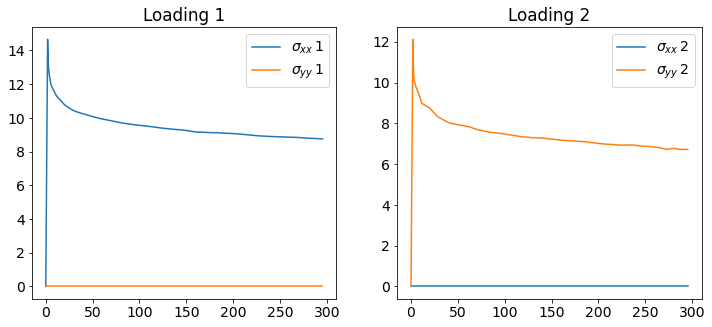

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(time[0], sgm_x[0], label='$\sigma_{xx} \, 1$')
ax[0].plot(time[0], sgm_y[0], label='$\sigma_{yy} \, 1$')
ax[0].set(title='Loading 1')

ax[1].plot(time[0], sgm_x[1], label='$\sigma_{xx} \, 2$')
ax[1].plot(time[0], sgm_y[1], label='$\sigma_{yy} \, 2$')
ax[1].set(title='Loading 2')

ax[0].legend()
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_pr,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(RG_params, RG_norm, False, time[0], lmb_x[0], lmb_y[0])
t = inp[0,0]
ax[1].plot(t, sgm_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(t, sgm_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(t, sgm_x[0], 'b.')
ax[1].plot(t, sgm_y[0], 'g.')

ax[0].plot(t, inp[0,1], label='$\lambda_x$')
ax[0].plot(t, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

(<matplotlib.legend.Legend at 0x298356740>,
 <matplotlib.legend.Legend at 0x2984f7520>)

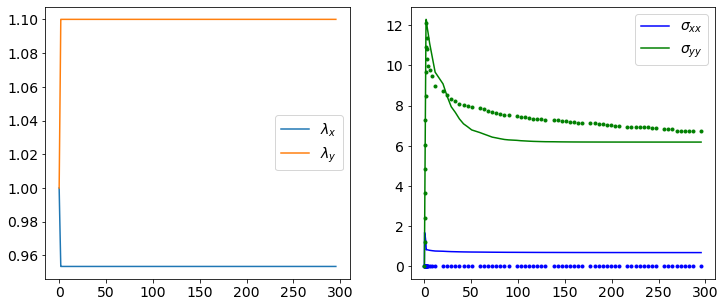

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_pr,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(RG_params, RG_norm, False, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sgm_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

In [ ]:
lr = 1.0e-3 #Set to 5.0e-4 if this doesn't work.
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(RG_params)

RG_params, train_loss, val_loss = train(inp, out, RG_norm, False, opt_state, key, biaxial_relax_batch_loss, nIter = 20000, batch_size=2, print_freq=100)
with open('saved/myocardium_RG_params.npy', 'wb') as f:
    pickle.dump(RG_params, f)

it 0, train loss = 3.378642e-01
it 100, train loss = 3.376942e-01
it 200, train loss = 3.376139e-01
it 300, train loss = 3.375092e-01
it 400, train loss = 3.374046e-01
it 500, train loss = 3.373002e-01
it 600, train loss = 3.371962e-01
it 700, train loss = 3.370918e-01
it 800, train loss = 3.369840e-01
it 900, train loss = 3.370970e-01
it 1000, train loss = 3.368381e-01
it 1100, train loss = 3.366831e-01
it 1200, train loss = 3.366309e-01
it 1300, train loss = 3.365246e-01
it 1400, train loss = 3.364219e-01
it 1500, train loss = 3.363203e-01
it 1600, train loss = 3.362192e-01
it 1700, train loss = 3.361185e-01
it 1800, train loss = 3.360179e-01
it 1900, train loss = 3.359175e-01
it 2000, train loss = 3.358173e-01
it 2100, train loss = 3.357172e-01
it 2200, train loss = 3.356173e-01
it 2300, train loss = 3.355175e-01
it 2400, train loss = 3.354178e-01
it 2500, train loss = 3.353183e-01
it 2600, train loss = 3.352190e-01
it 2700, train loss = 3.351198e-01
it 2800, train loss = 3.350208e-

(<matplotlib.legend.Legend at 0x298e18430>,
 <matplotlib.legend.Legend at 0x298e40f40>)

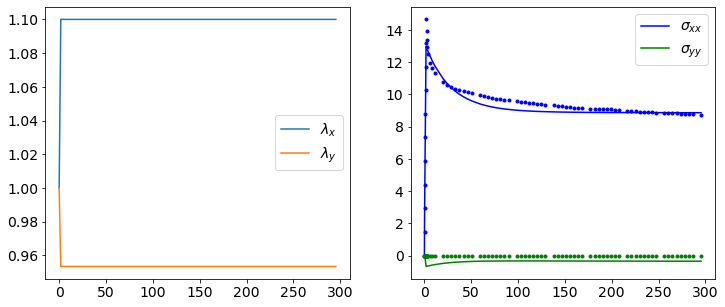

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(RG_params, RG_norm, False, inp[0,0], inp[0,1], inp[0,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[0], 'b.')
ax[1].plot(time, sgm_y[0], 'g.')

ax[0].plot(time, inp[0,1], label='$\lambda_x$')
ax[0].plot(time, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

(<matplotlib.legend.Legend at 0x298cd7580>,
 <matplotlib.legend.Legend at 0x298f40220>)

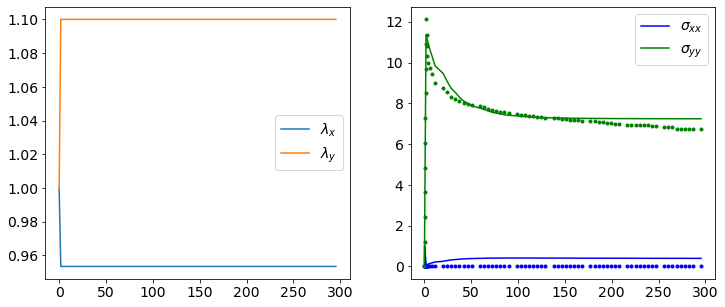

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(RG_params, RG_norm, False, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

In [ ]:
# Train Psi_EQ and Psi_NEQ of matrix
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_M_params

In [ ]:
lmb_z = 1/(lmb_x.flatten()*lmb_y.flatten())
lmb = np.transpose(np.array([lmb_x.flatten(), lmb_y.flatten(), lmb_z]))
lmb = lmb[::2]

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_eq_params)
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_eq_params
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)
    
with open('saved/myocardium_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 1.560520e+00
it 10000, train loss = 6.754902e-03
it 20000, train loss = 4.069934e-03
it 30000, train loss = 2.164820e-03
it 40000, train loss = 8.922475e-04
it 50000, train loss = 2.007971e-04
it 60000, train loss = 2.245837e-05
it 70000, train loss = 8.638255e-06
it 80000, train loss = 8.301716e-06
it 90000, train loss = 8.153030e-06
it 100000, train loss = 7.900378e-06
it 110000, train loss = 7.778958e-06
it 120000, train loss = 7.731250e-06
it 130000, train loss = 7.487153e-06
it 140000, train loss = 8.125624e-06
it 150000, train loss = 7.308583e-06
it 160000, train loss = 7.156983e-06
it 170000, train loss = 6.959901e-06
it 180000, train loss = 6.951204e-06
it 190000, train loss = 6.824188e-06
it 200000, train loss = 6.547172e-06


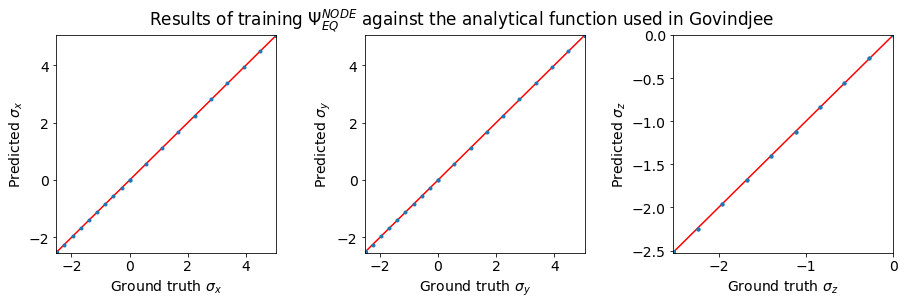

In [ ]:
sigma_pr = sigma_split_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), RG_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

In [ ]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_neq_params
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)

with open('saved/myocardium_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 1.489273e-02
it 10000, train loss = 5.548348e-03
it 20000, train loss = 1.159574e-03
it 30000, train loss = 4.963823e-04
it 40000, train loss = 1.304150e-04
it 50000, train loss = 1.360172e-05
it 60000, train loss = 6.596610e-06
it 70000, train loss = 6.476104e-06
it 80000, train loss = 6.332582e-06
it 90000, train loss = 3.976947e-06
it 100000, train loss = 1.930721e-06
it 110000, train loss = 7.302669e-07
it 120000, train loss = 2.487687e-07
it 130000, train loss = 1.297227e-07
it 140000, train loss = 1.118268e-07
it 150000, train loss = 1.125175e-07
it 160000, train loss = 1.086252e-07
it 170000, train loss = 1.077169e-07
it 180000, train loss = 1.215517e-07
it 190000, train loss = 1.061888e-07
it 200000, train loss = 1.059648e-07


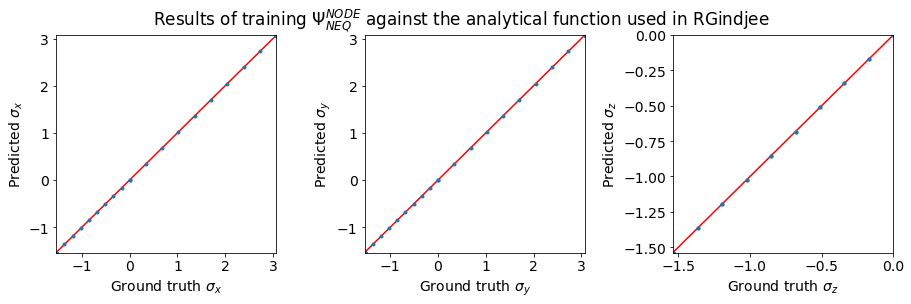

In [ ]:
sigma_pr = sigma_split_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), RG_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in RGindjee"
plot45(gts, prs, labels, title)

In [ ]:
# Train Phi
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_M_params
eta_D, eta_V = RG_Phi_params

In [ ]:
# Generate training data
# Input data and normalization factors
r = 1.0
taui = onp.mgrid[-r:r:10j, -r:r:10j, -r:r:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

# inp_std1 = onp.std(tau1)
# inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

# out_std1 = 1.0
# out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/onp.exp(eta_V)
out_std5 = 1/3/onp.exp(eta_D)
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 200000, batch_size=100, print_freq=10000)

with open('saved/myocardium_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/myocardium_Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 7.449382e+00
it 10000, train loss = 5.898195e-02
it 20000, train loss = 1.653962e-03
it 30000, train loss = 7.122185e-05
it 40000, train loss = 3.849609e-06
it 50000, train loss = 2.835402e-07
it 60000, train loss = 4.123618e-08
it 70000, train loss = 1.450507e-08
it 80000, train loss = 8.367350e-09
it 90000, train loss = 5.931947e-09
it 100000, train loss = 4.654378e-09
it 110000, train loss = 3.882306e-09
it 120000, train loss = 3.357276e-09
it 130000, train loss = 2.988108e-09
it 140000, train loss = 2.708883e-09
it 150000, train loss = 2.488135e-09
it 160000, train loss = 2.298049e-09
it 170000, train loss = 2.137430e-09
it 180000, train loss = 2.003115e-09
it 190000, train loss = 1.867072e-09
it 200000, train loss = 1.753789e-09


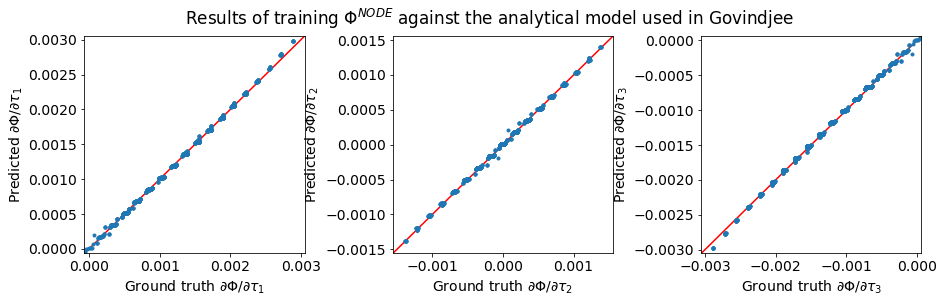

In [ ]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

In [ ]:
# Train Psi_EQ_F
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
k_EQ, k_NEQ, visc_params = RG_F_params

In [ ]:
Psi_EQ_F_params = init_params_nobias(layers, key)
inp = np.linspace(1,3)
k = np.ones_like(inp)*k_EQ

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_EQ_F_params)
Psi_EQ_F_params, train_loss, val_loss = train(inp, k, None, False, opt_state, key, Psi_F_loss, nIter = 200000, batch_size=50, print_freq=10000)
with open('saved/myocardium_Psi_EQ_F_params.npy', 'wb') as f:
    pickle.dump(Psi_EQ_F_params, f)

it 0, train loss = 1.339697e+02
it 10000, train loss = 1.022881e-01
it 20000, train loss = 3.760094e-02
it 30000, train loss = 4.741567e-04
it 40000, train loss = 8.776761e-05
it 50000, train loss = 8.641873e-05
it 60000, train loss = 8.503878e-05
it 70000, train loss = 8.362539e-05
it 80000, train loss = 8.217286e-05
it 90000, train loss = 8.067668e-05
it 100000, train loss = 7.913032e-05
it 110000, train loss = 7.755268e-05
it 120000, train loss = 7.584390e-05
it 130000, train loss = 7.440949e-05
it 140000, train loss = 8.210274e-05
it 150000, train loss = 7.031387e-05
it 160000, train loss = 6.827668e-05
it 170000, train loss = 6.613555e-05
it 180000, train loss = 6.389840e-05
it 190000, train loss = 6.154652e-05
it 200000, train loss = 5.910396e-05


In [ ]:
k = np.ones_like(inp)*k_NEQ

Psi_NEQ_F_params = init_params_nobias(layers, key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_NEQ_F_params)
Psi_NEQ_F_params, train_loss, val_loss = train(inp, k, None, False, opt_state, key, Psi_F_loss, nIter = 200000, batch_size=50, print_freq=10000)
with open('saved/myocardium_Psi_NEQ_F_params.npy', 'wb') as f:
    pickle.dump(Psi_NEQ_F_params, f)

it 0, train loss = 1.507779e+02
it 10000, train loss = 7.199511e-04
it 20000, train loss = 1.302870e-06
it 30000, train loss = 1.662374e-07
it 40000, train loss = 8.543917e-08
it 50000, train loss = 8.681415e-11
it 60000, train loss = 8.617708e-11
it 70000, train loss = 8.586914e-11
it 80000, train loss = 8.564364e-11
it 90000, train loss = 8.535931e-11
it 100000, train loss = 8.510967e-11
it 110000, train loss = 8.486142e-11
it 120000, train loss = 8.461406e-11
it 130000, train loss = 8.436724e-11
it 140000, train loss = 8.412189e-11
it 150000, train loss = 8.387676e-11
it 160000, train loss = 8.363260e-11
it 170000, train loss = 8.338958e-11
it 180000, train loss = 8.315112e-11
it 190000, train loss = 8.290416e-11
it 200000, train loss = 8.266223e-11


In [ ]:
# Train Phi_F
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
k_EQ, k_NEQ, visc_params = RG_F_params
theta, eta_F = visc_params

In [ ]:
inp = np.linspace(-1,+1)
eta_F = np.ones_like(inp)*eta_F

fiber_visc_params = init_params_nobias(layers, key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(fiber_visc_params)
fiber_visc_params, train_loss, val_loss = train(inp, eta_F, None, False, opt_state, key, Phi_F_loss, nIter = 200000, batch_size=50, print_freq=10000)
with open('saved/myocardium_fiber_visc_params.npy', 'wb') as f:
    pickle.dump(fiber_visc_params, f)

it 0, train loss = 3.705351e+01
it 10000, train loss = 2.118755e-06
it 20000, train loss = 1.015956e-06
it 30000, train loss = 1.185985e-07
it 40000, train loss = 2.484197e-10
it 50000, train loss = 5.125325e-12
it 60000, train loss = 4.416741e-12
it 70000, train loss = 3.387514e-10
it 80000, train loss = 4.364155e-12
it 90000, train loss = 4.336981e-12
it 100000, train loss = 4.332108e-12
it 110000, train loss = 4.344715e-12
it 120000, train loss = 4.258538e-12
it 130000, train loss = 9.117174e-12
it 140000, train loss = 4.206830e-12
it 150000, train loss = 2.607082e-09
it 160000, train loss = 4.155934e-12
it 170000, train loss = 4.244568e-12
it 180000, train loss = 4.105424e-12
it 190000, train loss = 4.174486e-12
it 200000, train loss = 8.071926e-10


In [ ]:
M_params = (Psi_eq_params, Psi_neq_params, Phi_params)
Phi_F_params = (theta, fiber_visc_params)
F_params = (Psi_EQ_F_params, Psi_NEQ_F_params, Phi_F_params)
params = (M_params, F_params)
with open('saved/myocardium_params.npy', 'wb') as f:
    pickle.dump(params, f)
norm = (None, None, Phi_norm)

#### Retrain

In [7]:
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
with open('saved/myocardium_params.npy', 'rb') as f:
    params = pickle.load(f)
with open('saved/myocardium_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
norm = (None, None, Phi_norm)

with open('training_data/myocardium/Stress relaxation/combined.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)
inp = np.array([time, lmb_x, lmb_y]).transpose([1,0,2])
out = np.array([sgm_x, sgm_y]).transpose([1,0,2])

(<matplotlib.legend.Legend at 0x1642543d0>,
 <matplotlib.legend.Legend at 0x1642546d0>)

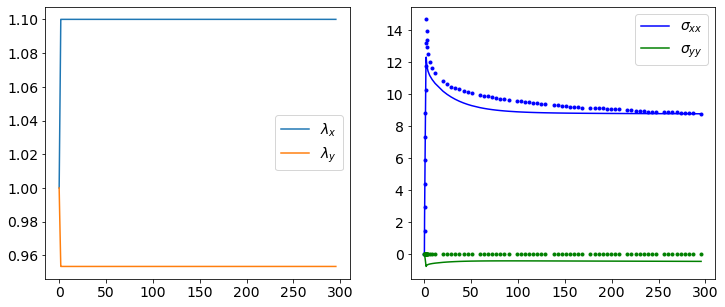

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(params, norm, True, inp[0,0], inp[0,1], inp[0,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[0], 'b.')
ax[1].plot(time, sgm_y[0], 'g.')

ax[0].plot(time, inp[0,1], label='$\lambda_x$')
ax[0].plot(time, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

(<matplotlib.legend.Legend at 0x167d0a410>,
 <matplotlib.legend.Legend at 0x1676c4370>)

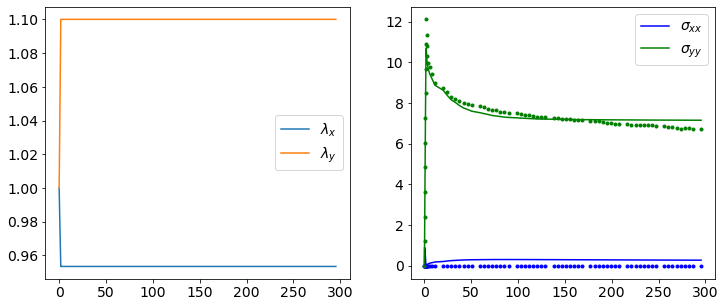

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(params, norm, True, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

In [ ]:
lr = 1.0e-4 #1.0e-3 x 200 + 1.0e-4 x 140
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, biaxial_relax_batch_loss, nIter = 140, batch_size=2, print_freq=20)
with open('saved/myocardium_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

RG MAE  0.3273623534744295
RG MRE  0.04451081439717823
NODE MAE  0.18653359537548328
NODE MRE  0.023868381449124346


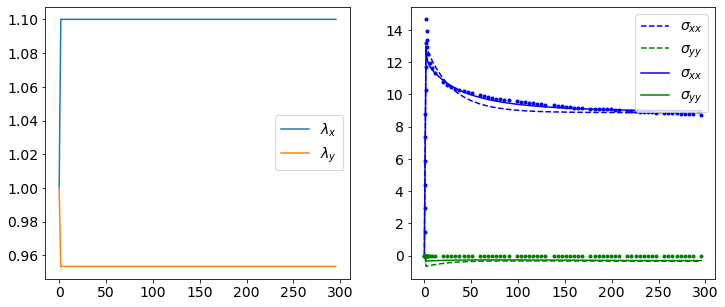

In [30]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_rg,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(RG_params, norm, False, inp[0,0], inp[0,1], inp[0,2])
sgm_nn,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(params, norm, True, inp[0,0], inp[0,1], inp[0,2])
time = inp[0,0]
ax[1].plot(time, sgm_rg[:,0,0], 'b--', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_rg[:,1,1], 'g--', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_nn[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_nn[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[0], 'b.')
ax[1].plot(time, sgm_y[0], 'g.')

ax[0].plot(time, inp[0,1], label='$\lambda_x$')
ax[0].plot(time, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

# Save for TikZ
# header = ['x', 'y_gt', 'y_nn', 'y_rg']
# df = pd.DataFrame(np.array([time, sgm_x[0], sgm_nn[:,0,0], sgm_rg[:,0,0]], dtype=np.float16).T, columns=header)
# df.to_csv('tikz_data/fig_myocardium1/fig_myocardium1_a.csv', index=False, sep=' ')

print('RG MAE ', np.mean(np.abs(sgm_rg[:,0,0]-sgm_x[0])))
print('RG MRE ', np.mean((np.abs(sgm_rg[1:,0,0]-sgm_x[0,1:])/sgm_x[0,1:])))

print('NODE MAE ', np.mean(np.abs(sgm_nn[:,0,0]-sgm_x[0])))
print('NODE MRE ', np.mean((np.abs(sgm_nn[1:,0,0]-sgm_x[0,1:])/sgm_x[0,1:])))

RG MAE  0.27146980514207236
RG MRE  0.03662832131376431
NODE MAE  0.1450253870913673
NODE MRE  0.022285190315264124


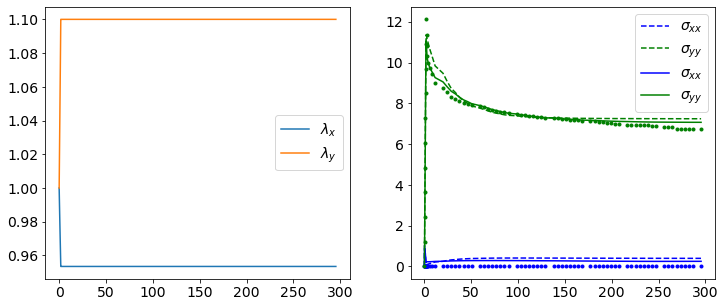

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_rg,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(RG_params, norm, False, inp[1,0], inp[1,1], inp[1,2])
sgm_nn,lm1,lm2,lm3,_,_,_,lm_F_v, residual = biaxial_relax_aniso(params, norm, True, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sgm_rg[:,0,0], 'b--', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_rg[:,1,1], 'g--', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_nn[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_nn[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

# Save for TikZ
header = ['x', 'y_gt', 'y_nn', 'y_rg']
df = pd.DataFrame(np.array([time, sgm_y[1], sgm_nn[:,1,1], sgm_rg[:,1,1]], dtype=np.float16).T, columns=header)
df.to_csv('tikz_data/fig_myocardium1/fig_myocardium1_b.csv', index=False, sep=' ')


print('RG MAE ', np.mean(np.abs(sgm_rg[:,1,1]-sgm_y[1])))
print('RG MRE ', np.mean((np.abs(sgm_rg[1:,1,1]-sgm_y[1,1:])/sgm_y[1,1:])))

print('NODE MAE ', np.mean(np.abs(sgm_nn[:,1,1]-sgm_y[1])))
print('NODE MRE ', np.mean((np.abs(sgm_nn[1:,1,1]-sgm_y[1,1:])/sgm_y[1,1:])))

In [34]:
0.5*(0.03662832131376431 + 0.04451081439717823)

0.04056956785547127

In [35]:
0.5*(0.022285190315264124 + 0.023868381449124346)

0.023076785882194237

In [34]:
# Test with cyclic data
with open('saved/myocardium_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
@partial(jit, static_argnums=(1,2,))
def biaxial_cyclic_aniso(params, norm, useNODE, time1, time2, lm1dot, lm2dot, dt0=0.5):
    M_params, F_params = params
    
    # Matrix part
    solver = mysolver()

    # Load
    tpeak1 = time1[-1]
    yprime = lambda t, y, args: np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak1,M_params,norm,useNODE))
    term = ODETerm(yprime)
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time1)
    solution = diffeqsolve(term, solver, t0=0, t1=time1[-1], dt0=dt0, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()
    sgm_M = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], M_params, norm, useNODE)

    # Unload
    tpeak2 = time2[-1]
    yprime = lambda t, y, args: np.array(yprime_biaxial(y,t,-lm1dot,-lm2dot,tpeak2,M_params,norm,useNODE))
    term = ODETerm(yprime)
    y0 = np.array([lm1[-1],lm2[-1],lm3[-1],lm1e[-1],lm2e[-1],lm3e[-1]])
    saveat = SaveAt(ts=time2)
    solution = diffeqsolve(term, solver, t0=time2[0], t1=time2[-1], dt0=dt0, y0=y0, saveat=saveat)
    lm1_2, lm2_2, lm3_2, lm1e_2, lm2e_2, lm3e_2 = solution.ys.transpose()
    sgm_M_2 = getsigma([lm1_2,lm2_2,lm3_2,lm1e_2,lm2e_2,lm3e_2], M_params, norm, useNODE)
    
    # Combine the two
    lm1 = np.hstack([lm1,lm1_2])
    lm2 = np.hstack([lm2,lm2_2])
    lm3 = np.hstack([lm3,lm3_2])
    lm1e = np.hstack([lm1e,lm1e_2])
    lm2e = np.hstack([lm2e,lm2e_2])
    lm3e = np.hstack([lm3e,lm3e_2])
    sgm_M = np.vstack([sgm_M, sgm_M_2])
    
    # Fiber part
    inp = np.array([time[1:], lm1[1:], lm2[1:], lm3[1:],]).T
    init = [1.0, 0.0] #initial lm_F_v and time
    body_fun = lambda prev, inp: fiber_biaxial_update(prev, inp, F_params, useNODE)
    _, [sgm_F, lm_F_v, res] = scan(body_fun, init, inp)
    sgm_F = np.vstack([np.zeros([1,3,3]), sgm_F])
    sgm = sgm_F + sgm_M

    return sgm, lm1, lm2, lm3, lm1e, lm2e, lm3e, lm_F_v, res

In [23]:
with open('training_data/myocardium/Cyclic/3mmmin/MFD.npy', 'rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)
ipeak = np.where(lmb_x == np.max(lmb_x))[0][0]
time1 = time[:ipeak]
time2 = time[ipeak:]
lm1dot = 0.1/80.0 #0.1 stretch in 80 sec
lm2dot = 0.0

In [38]:
sgm, lm1, lm2, lm3, lm1e, lm2e, lm3e, lm_F_v, res = biaxial_cyclic_aniso(params, norm, True, time1, time2, lm1dot, lm2dot)

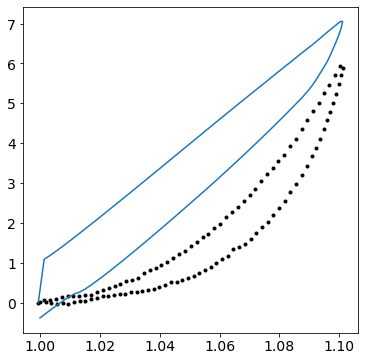

In [43]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(lmb_x, sgm_x, 'k.')
ax.plot(lmb_x, sgm[:,0,0])

In [44]:
with open('training_data/myocardium/Cyclic/10mmmin/MFD.npy', 'rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)
ipeak = np.where(lmb_x == np.max(lmb_x))[0][0]
time1 = time[:ipeak]
time2 = time[ipeak:]
lm1dot = 0.1/24.0 #0.1 stretch in 80 sec
lm2dot = 0.0

In [45]:
sgm, lm1, lm2, lm3, lm1e, lm2e, lm3e, lm_F_v, res = biaxial_cyclic_aniso(params, norm, True, time1, time2, lm1dot, lm2dot)

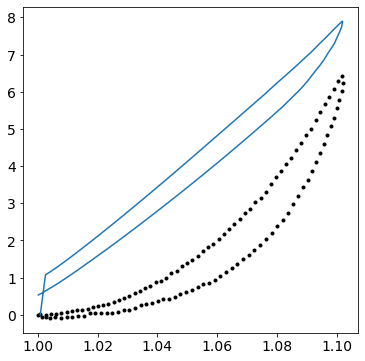

In [46]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(lmb_x, sgm_x, 'k.')
ax.plot(lmb_x, sgm[:,0,0])